<a href="https://colab.research.google.com/github/yang-song/score_sde_pytorch/blob/main/Score_SDE_demo_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

1. `git clone https://github.com/yang-song/score_sde_pytorch.git`

2. Install [required packages](https://github.com/yang-song/score_sde_pytorch/blob/main/requirements.txt)

3. `cd` into folder `score_sde_pytorch`, launch a local jupyter server and connect to colab following [these instructions](https://research.google.com/colaboratory/local-runtimes.html)

4. Download pre-trained [checkpoints](https://drive.google.com/drive/folders/1tFmF_uh57O6lx9ggtZT_5LdonVK2cV-e?usp=sharing) and save them in the `exp` folder.

In [1]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [7]:
x=torch.zeros([3], dtype=torch.float32)
x[1]=1
x

tensor([0., 1., 0.])

In [8]:
from configs.subvp import mvtec_ncsnpp_continuous as configs
config = configs.get_config()
# config.eval.batch_size = 256

In [12]:
"category" in config.data

True

In [3]:
config

data:
  category: hazelnut
  centered: true
  dataset: MVTEC
  dir_path: /DATA/Users/amahmood/GDrive/MVTec_AD/
  downsample_size: 200
  image_size: 128
  num_channels: 3
  random_flip: true
  uniform_dequantization: false
device: !!python/object/apply:torch.device
- cuda
- 0
eval:
  batch_size: 16
  begin_ckpt: 3
  bpd_dataset: ood
  enable_bpd: true
  enable_loss: true
  enable_sampling: false
  end_ckpt: 3
  num_samples: 50000
  ood_eval: true
model:
  attention_type: ddpm
  attn_resolutions: !!python/tuple
  - 16
  beta_max: 20.0
  beta_min: 0.1
  ch_mult: !!python/tuple
  - 1
  - 2
  - 2
  - 2
  conditional: true
  conv_size: 3
  dropout: 0.0
  ema_rate: 0.9999
  embedding_type: positional
  fir: true
  fir_kernel:
  - 1
  - 3
  - 3
  - 1
  fourier_scale: 16
  init_scale: 0.0
  name: ncsnpp
  nf: 64
  nonlinearity: swish
  normalization: GroupNorm
  num_res_blocks: 4
  num_scales: 2000
  progressive: none
  progressive_combine: sum
  progressive_input: residual
  resamp_with_conv: 

In [48]:
# Setup SDE
import sde_lib
sde = sde_lib.subVPSDE(
    beta_min=config.model.beta_min,
    beta_max=config.model.beta_max,
    N=config.model.num_scales,
)
sampling_eps = 1e-3

In [56]:
n_timesteps=10
eps=1e-5
torch.linspace(sde.T, eps, n_timesteps, device="cpu")

tensor([1.0000e+00, 8.8889e-01, 7.7778e-01, 6.6667e-01, 5.5556e-01, 4.4445e-01,
        3.3334e-01, 2.2223e-01, 1.1112e-01, 1.0000e-05])

In [64]:
t=torch.linspace(sde.T, eps, n_timesteps, device="cpu")
std = sde.marginal_prob(torch.zeros_like(t), t)[1].numpy()
std

array([9.9995679e-01, 9.9964756e-01, 9.9775028e-01, 9.8876739e-01,
       9.5613301e-01, 8.6600149e-01, 6.7983985e-01, 4.0167153e-01,
       1.2538469e-01, 1.0132790e-06], dtype=float32)

In [4]:
score_dir = "workdir/mvtec/scores/"
eval_dir = "workdir/mvtec/eval/"

ckpt=3
with open(os.path.join(eval_dir, f"ckpt_{ckpt}_loss.npz"), "rb") as f:
    data = np.load(f)
    losses  = data["all_losses"]
    print(f"Mean Loss: {data['mean_loss']:.4f}")

Mean Loss: 0.0720


In [89]:
import pathlib

dataset_dir = f"{config.data.dir_path}/{config.data.category}"
dataset_builder = tfds.ImageFolder(dataset_dir)

train_dir = pathlib.Path(f"{dataset_dir}/train/")
test_dir = pathlib.Path(f"{dataset_dir}/test/")
seg_dir = pathlib.Path(f"{dataset_dir}/ground_truth/")
print(train_dir, test_dir, seg_dir, sep="\n")

LABELS = sorted(os.listdir(f"{test_dir}"))

dataset_builder.info, LABELS

/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/train
/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/test
/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/ground_truth


(tfds.core.DatasetInfo(
     name='image_folder',
     full_name='image_folder/1.0.0',
     description="""
     Generic image classification dataset.
     """,
     homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
     data_path='/DATA/Users/amahmood/GDrive/MVTec_AD//hazelnut',
     download_size=Unknown size,
     dataset_size=Unknown size,
     features=FeaturesDict({
         'image': Image(shape=(None, None, 3), dtype=tf.uint8),
         'image/filename': Text(shape=(), dtype=tf.string),
         'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
     }),
     supervised_keys=('image', 'label'),
     disable_shuffling=False,
     splits={
         'ground_truth': <SplitInfo num_examples=70, num_shards=1>,
         'test': <SplitInfo num_examples=110, num_shards=1>,
         'train': <SplitInfo num_examples=391, num_shards=1>,
     },
     citation="""""",
 ),
 ['crack', 'cut', 'good', 'hole', 'print'])

In [87]:
test_ds = dataset_builder.as_dataset(
                split="test", shuffle_files=False
            )
test_labels = [int(x["label"]) for x in test_ds]
test_labels[:10]

[0, 4, 0, 1, 1, 4, 0, 1, 2, 2]

In [100]:
ckpt="latest"
fname=os.path.join(score_dir, f"ckpt_{ckpt}_scores.npz")
with np.load(fname, allow_pickle=True) as data:
    train_scores = data["train"]
    eval_scores = data["eval"]
    test_scores = data["test"]
    ood_scores = data["ood"]
    
fname=os.path.join(score_dir, f"ckpt_{ckpt}_score_norms.npz")
with np.load(fname, allow_pickle=True) as data:
    train_score_norms = data["train"]
    eval_score_norms = data["eval"]
    test_score_norms = data["test"]
    ood_score_norms = data["ood"]

In [101]:
eval_score_norms.shape

(10, 39)

In [102]:
recordify = lambda ds,name: [(i, x, name) for i, scores in enumerate(ds) for x in scores ]

In [111]:
train_recs = recordify(train_score_norms, "train")
eval_recs = recordify(eval_score_norms, "eval")
test_recs = recordify(test_score_norms, "test")
ood_recs = recordify(ood_score_norms, "ood")
eval_recs[:4]

[(0, 77.07271147555497, 'eval'),
 (0, 79.2570959568063, 'eval'),
 (0, 76.91147258440321, 'eval'),
 (0, 76.16955543240283, 'eval')]

In [112]:
df = pd.DataFrame.from_records(eval_recs+test_recs+ood_recs, columns=["sigma", "score", "dataset"])
df

,sigma,score,dataset
0,0,77.072711,eval
1,0,79.257096,eval
2,0,76.911473,eval
3,0,76.169555,eval
4,0,82.119197,eval
...,...,...,...
1485,9,0.000003,ood
1486,9,0.000003,ood
1487,9,0.000003,ood
1488,9,0.000003,ood


(50.0, 80.0)

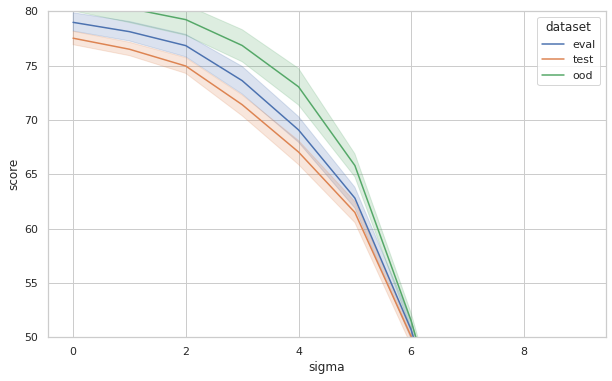

In [113]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=df, x="sigma", y="score", hue="dataset", ci=99, ax=ax)
plt.ylim(50,80)

========================= Training GMM =========================
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best: -2.501314 using {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
---------------------------------------------------------------------------
-2.501314 (0.382622) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 1}


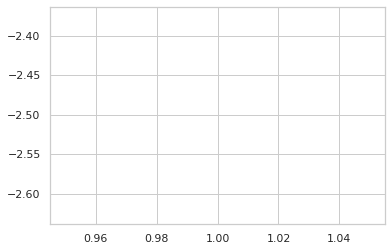

---Likelihoods---
Training: -2.331
Inlier: -2.572
OOD: -19.524
========================= Training Flow Model =========================
Epoch 1/10000
12/12 [==============================] - 1s 29ms/step - loss: 20748.5346 - val_loss: 14629.7207
Epoch 2/10000
12/12 [==============================] - 0s 9ms/step - loss: 14223.0777 - val_loss: 11362.2451
Epoch 3/10000
12/12 [==============================] - 0s 9ms/step - loss: 11324.4402 - val_loss: 9596.2969
Epoch 4/10000
12/12 [==============================] - 0s 9ms/step - loss: 9690.5005 - val_loss: 8433.9043
Epoch 5/10000
12/12 [==============================] - 0s 9ms/step - loss: 8525.3682 - val_loss: 7592.8867
Epoch 6/10000
12/12 [==============================] - 0s 10ms/step - loss: 7709.2015 - val_loss: 6939.3955
Epoch 7/10000
12/12 [==============================] - 0s 9ms/step - loss: 7018.1656 - val_loss: 6421.7686
Epoch 8/10000
12/12 [==============================] - 0s 9ms/step - loss: 6512.8729 - val_loss: 5990.3164
Ep

In [ ]:
from ood_detection_helper import *

X_train = np.concatenate((eval_score_norms.T, train_score_norms.T), axis=0)
X_test = test_score_norms.T
X_ood = [ood_score_norms.T]
metrics = auxiliary_model_analysis(
    X_train,
    X_test,
    X_ood,
    components_range=range(1, 2, 1),
    labels=["Train", "Inlier", "OOD"],
    flow_epochs=10000,
    verbose=1
)

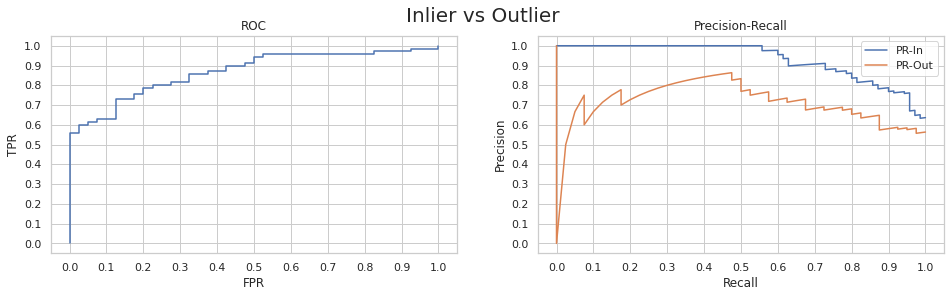

Inlier vs Outlier
----------------
ROC-AUC: 86.7500
PR-AUC (In/Out): 93.1323 / 70.6013
FPR (95% TPR): 17.50%
Detection Error: 19.82%


,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
OOD,93.179675,19.821429,7.5,17.5,93.132265,70.601313,86.75


In [135]:
ood_metrics(-metrics["GMM"]["test_scores"], -metrics["GMM"]["ood_scores"][0], plot=True, verbose=True)
metrics["GMM"]["metrics"]

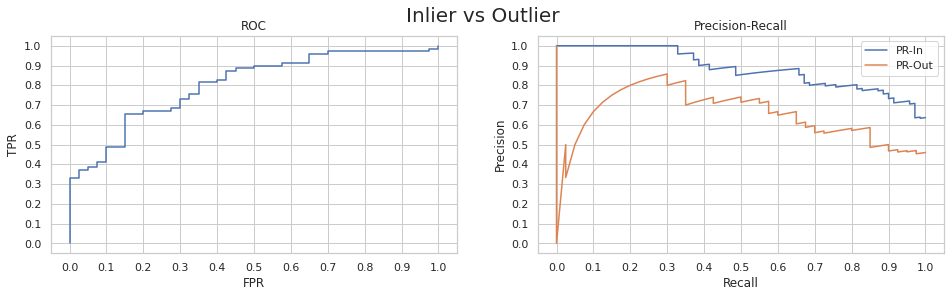

Inlier vs Outlier
----------------
ROC-AUC: 80.2500
PR-AUC (In/Out): 88.3633 / 64.3256
FPR (95% TPR): 32.50%
Detection Error: 24.64%


,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
OOD,88.46107,24.642857,15.0,32.5,88.36328,64.325613,80.25


In [136]:
ood_metrics(metrics["KD"]["test_scores"], metrics["KD"]["ood_scores"][0], plot=True, verbose=True)
metrics["KD"]["metrics"]

In [ ]:
ood_metrics(-metrics["Flow"]["test_scores"], -metrics["Flow"]["ood_scores"][0], plot=True, verbose=True)
metrics["Flow"]["metrics"]

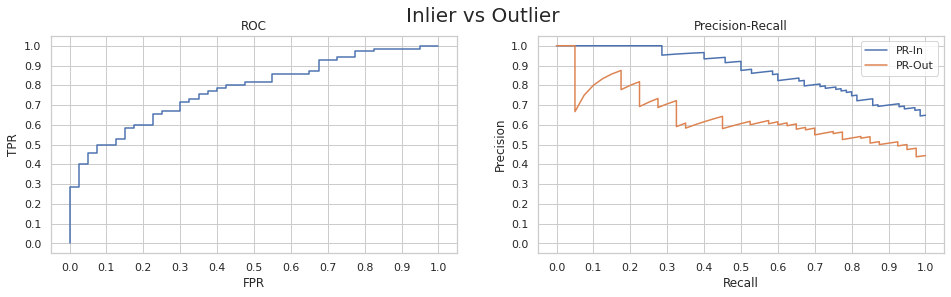

Inlier vs Outlier
----------------
ROC-AUC: 77.9286
PR-AUC (In/Out): 87.5800 / 64.3024
FPR (95% TPR): 35.00%
Detection Error: 28.21%


,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
OOD,87.68018,28.214286,22.5,35.0,87.580041,64.302425,77.928571


In [144]:
ood_metrics(-metrics["Flow"]["test_scores"], -metrics["Flow"]["ood_scores"][0], plot=True, verbose=True)
metrics["Flow"]["metrics"]

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

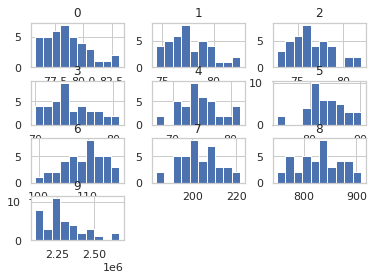

In [12]:
df = pd.DataFrame(score_norms.T)

In [4]:
ckpt_filename = "workdir/mvtec/checkpoints/checkpoint_1.pth"
sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3

batch_size =  16
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

In [10]:
#@title Visualization code

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


# Likelihood

In [51]:
workdir = "workdir/mvtec"
eval_folder = "eval"
eval_dir = os.path.join(workdir, eval_folder)

ckpt = 3

# Create data loaders for ood evaluation. Only evaluate on uniformly dequantized data

train_ds_bpd, eval_ds_bpd, _ = datasets.get_dataset(
    config, uniform_dequantization=True, evaluation=True, ood_eval=False
)

inlier_ds_bpd, ood_ds_bpd, _ = datasets.get_dataset(
    config, uniform_dequantization=True, evaluation=True, ood_eval=True
)

bpd_datasets = {"ood":ood_ds_bpd, "test":eval_ds_bpd, "inlier":inlier_ds_bpd}
bpds = {}
num_runs = 5

for name, ds in bpd_datasets.items():
    # Getting the firs run for now
    
    n = len(ds)
    bs = config.eval.batch_size
    
    # Build initaila array of likelihoods since dataseize is not known at runtime
    batch_bpd = []
    for i in range(1, n+1):
        fname = os.path.join(eval_dir,
                             f"{name}_ckpt_{ckpt}_bpd_{(i-1)}.npz"
                            )
        with np.load(fname) as data:
            data = np.asarray(data['arr_0'])
            batch_bpd.extend(data)
    batch_bpd = np.asarray(batch_bpd)
    
    for r in range(1, num_runs):
        for i in range(1, n+1):
            fname = os.path.join(eval_dir,
                                 f"{name}_ckpt_{ckpt}_bpd_{(i-1)+r*n}.npz"
                                )
            with np.load(fname) as data:
                data = np.asarray(data['arr_0'])
                start = (i-1) * bs
                end = start + len(data)
#                 print(i,start,end, data.shape)
                batch_bpd[start:end] += data
    
    batch_bpd /= num_runs
    bpds[name] = batch_bpd
    
    print(f"Avg likelihood for {name} set: {batch_bpd.mean():.3f}")

Avg likelihood for ood set: 2.126
Avg likelihood for test set: 2.329


<AxesSubplot:ylabel='Count'>

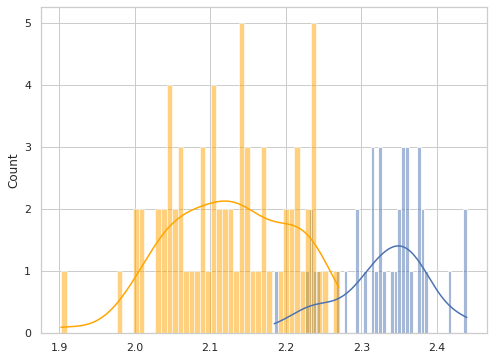

In [55]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.histplot(bpds["test"], bins=50, kde=True, ax=ax)
sns.histplot(bpds["ood"], bins=50, kde=True, color="orange", ax=ax)

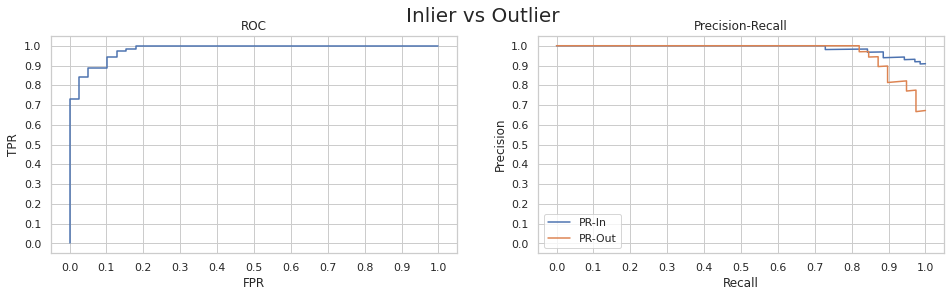

Inlier vs Outlier
----------------
ROC-AUC: 98.0586
PR-AUC (In/Out): 98.8779 / 97.1509
FPR (95% TPR): 2.56%
Detection Error: 7.84%


{'fpr_tpr95': 0.02564102564102564,
 'de': 0.07838827838827839,
 'roc_auc': 0.9805860805860805,
 'pr_auc_in': 0.9887792635327953,
 'pr_auc_out': 0.9715092676407291,
 'fpr_tpr80': 0.0,
 'ap': 0.9888633408837197}

In [54]:
from ood_detection_helper import ood_metrics

ood_metrics(-bpds["test"], -bpds["ood"], plot=True, verbose=True)

# Predictor Corrector sampling


Recommended settings:

 | dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

Check `probability_flow` to run PC sampling based on discretizing the probability flow ODE.

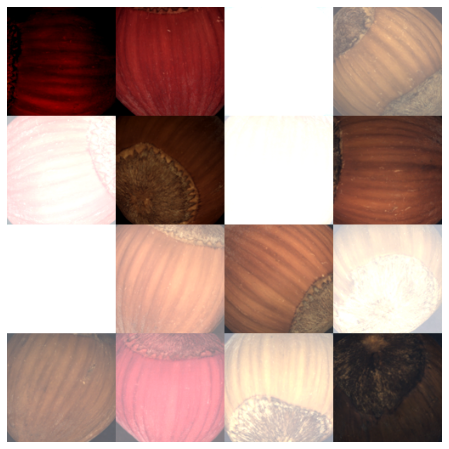

In [11]:
#@title PC sampling
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = EulerMaruyamaPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = None #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x, n = sampling_fn(score_model)
show_samples(x)